## Validate Model on Held-Out Subjects
This notebook applies the previously calculated model, using 10 test subjects, to the remaining 5 subjects from the same dataset that were not used at all to estimate the model. The same filters to eliminate mislabeled samples in the training data are applied to the validation data.  

In [2]:
import numpy as np
import pandas as pd
import random as rn

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import itertools



Using TensorFlow backend.


In [3]:
df = pd.read_pickle('./thigh_validate100.pkl')

In [4]:
df.head()

,attr_time_gyr,attr_x_gyr,attr_y_gyr,attr_z_gyr,attr_time_acc,attr_x_acc,attr_y_acc,attr_z_acc,activity,label,subject,sample_num
0,1436898151013,-0.131894,0.090647,0.000252,1436898151014,-4.435259,8.489840,-0.550068,climbingdown,0,11,0
1,1436898151031,-0.112652,0.141043,0.004528,1436898151033,-4.444836,8.537724,-0.687136,climbingdown,0,11,0
2,1436898151052,-0.097685,0.128215,0.022854,1436898151053,-4.267066,8.509591,-0.664990,climbingdown,0,11,0
3,1436898151072,-0.111430,0.079957,0.022549,1436898151073,-4.426879,8.510190,-0.612916,climbingdown,0,11,0
4,1436898151091,-0.108986,0.051246,0.025603,1436898151093,-4.394557,8.461109,-0.615908,climbingdown,0,11,0


In [5]:
df.label.value_counts()

7    164300
3    160800
6    158800
5    158400
4    157500
1    129900
0     78300
2     24700
Name: label, dtype: int64

In [6]:
df.activity.value_counts(1)

walking         0.159098
lying           0.155708
standing        0.153772
sitting         0.153384
running         0.152513
climbingup      0.125787
climbingdown    0.075821
jumping         0.023918
Name: activity, dtype: float64

### Find and drop mislabeled samples

In [7]:
deviation = df.groupby(['activity','subject','sample_num']).std()
deviation.reset_index(inplace=True)  # converts multiindex into columns

In [8]:
def find_bad_samples(activity,samples_to_drop,operator,threshold):
    mask =(df.activity == activity) & operator(df.attr_x_acc, threshold)
    return samples_to_drop.extend(list(df.sample_num[mask]))

In [9]:
import operator
df=deviation
samples_to_drop = []
find_bad_samples('climbingdown',samples_to_drop,operator.lt,1.2)
find_bad_samples('climbingup',samples_to_drop,operator.lt,1.2)
find_bad_samples('jumping',samples_to_drop,operator.lt,3.5)
find_bad_samples('lying',samples_to_drop,operator.gt,0.5)
find_bad_samples('running',samples_to_drop,operator.lt,5)
find_bad_samples('sitting',samples_to_drop,operator.gt,1)
find_bad_samples('walking',samples_to_drop,operator.lt,1.5)

In [12]:
thigh_validate = pd.read_pickle('./thigh_validate100.pkl')
df = thigh_validate[~thigh_validate.sample_num.isin(samples_to_drop)]

In [14]:
df.activity.value_counts(1)

walking         0.161427
standing        0.160518
sitting         0.158799
lying           0.158597
running         0.133832
climbingup      0.127262
climbingdown    0.076620
jumping         0.022946
Name: activity, dtype: float64

In [15]:
df.shape

(989300, 12)

### Predict activity classes using estimated model

In [16]:
X = df[['attr_x_gyr','attr_y_gyr','attr_z_gyr','attr_x_acc','attr_y_acc','attr_z_acc']]

In [17]:
X.shape

(989300, 6)

In [18]:
# Create y
y=df.label.groupby(df.sample_num).mean()
# y = to_categorical(y, 8)
y.shape

(9893,)

In [29]:
# scale the validation data based on the original training data
filename = "scaler_fit_to_train.pkl"  
sc = pickle.load( open(filename, "rb" )) 

In [20]:
X = sc.transform(X)

In [21]:
X = np.array(X).reshape((-1,100,6))  # reshape into a series of 150x3 arrays - windowsize x num_features

In [22]:
X.shape

(9893, 100, 6)

In [30]:
# read the previously estimated model
filename = "./model_10subjects_cnn.pkl"  
model = pickle.load( open(filename, "rb" )) 

In [24]:
# get accuracy measures per class
# source: https://stackoverflow.com/questions/45930750/how-to-output-per-class-accuracy-in-keras
# Y = np.argmax(y, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(X)
print(classification_report(y, y_pred, 
                            target_names=["climbingdown","climbingup","jumping","lying","running","sitting","standing","walking"]))

              precision    recall  f1-score   support

climbingdown       0.38      0.30      0.34       758
  climbingup       0.46      0.74      0.57      1259
     jumping       0.37      0.79      0.50       227
       lying       0.66      0.77      0.71      1569
     running       0.71      0.76      0.74      1324
     sitting       0.43      0.60      0.50      1571
    standing       0.97      0.79      0.87      1588
     walking       0.00      0.00      0.00      1597

    accuracy                           0.58      9893
   macro avg       0.50      0.59      0.53      9893
weighted avg       0.52      0.58      0.54      9893



In [26]:
# source: https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    
    plt.figure(figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout();

<Figure size 432x288 with 0 Axes>

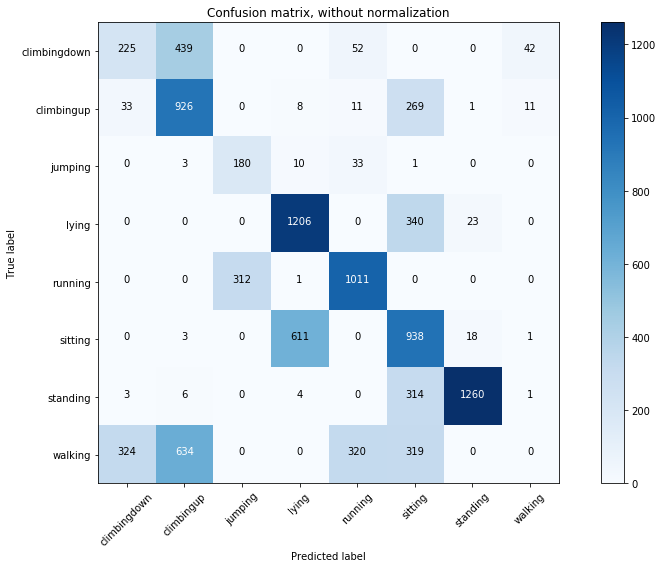

In [28]:
np.set_printoptions(precision=2)
cm = confusion_matrix(y, 
                      y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, 
                      classes=["climbingdown","climbingup","jumping","lying","running","sitting","standing","walking"],
                      title='Confusion matrix, without normalization');
